# CS342 Machine Learning Coursework:

# Multi-Class  Classification  with  Kernel-based  Latent  Factor  Models  and  Perceptrons



# I.A Dataset

Code to upload Iris.data dataset from /data directory to Python NumPy arrays:

In [1]:
import numpy as np
import pandas as pd

# Data is being uploaded from the iris.data file in the /data directory that exist
# in the same directory as coursework.ipynb file

# location of data can be changed changing the string below
location = "data/iris.data"

iris_x = np.loadtxt(location, delimiter=",", usecols=[0,1,2,3])

# Names first uploaded to Pandas DataFrame, then to NumPy arrays after changing
# labels to 0, 1 and 2
iris_names = pd.read_csv(location, usecols=[4], header=None)
names_dic = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
iris_names[4] = iris_names[4].apply(lambda x: names_dic[x])

iris_y = iris_names.to_numpy()


# II.A Data visualisation



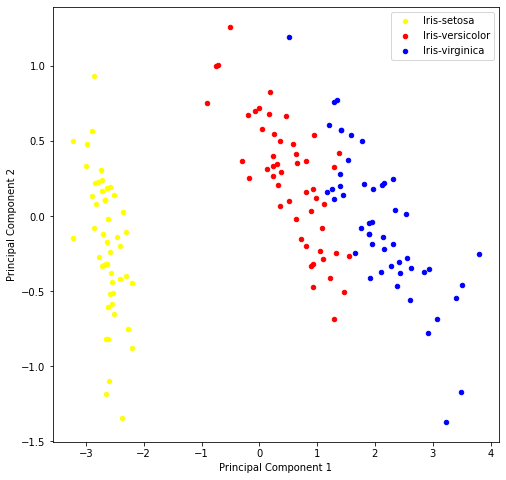

In [2]:
import matplotlib.pyplot as plt

# centering data for PCA
centered_x = iris_x - iris_x.mean(axis=0)

# singular value decomposition to get PCs 
U, S, V = np.linalg.svd(centered_x, full_matrices=True)

top2pcs = V[:2]

# projecting the data onto the top two principal components.
iris2D = centered_x.dot(np.transpose(top2pcs))

col_dict = {0: 'yellow', 1: 'red', 2: 'blue'}
labels_dict = {0: 'Iris-setosa',1: 'Iris-versicolor', 2:'Iris-virginica'}


# matplotlib to visualize Iris Dataset in 2 dimensions
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
for iris in np.unique(iris_y):
    ix = np.where(iris_y == iris)[0]
    ax.scatter(iris2D.T[0][ix], iris2D.T[1][ix], c=col_dict[iris], label = labels_dict[iris], s=20)
ax.legend()

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

As can be seen from the visual representation of Iris Dataset in 2 dimensions, Iris-setosa class can be linearly separated from Iris-versicolor and Iris-virginica classes. However, Iris-versicolor and Iris-virginica are not linearly separable.

# II.B Multi-class classification using a perceptron

In [3]:
from sklearn.utils import shuffle
import time

def perceptron(data_x, data_y, w):
    array = np.zeros((w.shape[0],1))
    data_x, data_y = shuffle(data_x, data_y)
    
    for i in range(0,50):
        for n in range(len(data_x)):
            for x in range(len(array)):
                array[x] = data_x[n].dot(w[x].T)
            
            index = np.argmax(array)
            if index != data_y[n]:
                for w_i in range(len(w)):
                    if w_i == data_y[n]:
                        w[w_i] += data_x[n]
                    else:
                        w[w_i] -= data_x[n]
            
        data_x, data_y = shuffle(data_x, data_y)
    return w


def accuracy(w, data_x, data_y):
    correct = 0
    array = np.zeros((w.shape[0],1))
    
    for i in range(len(data_x)):
        
        for x in range(len(array)):
                array[x] = data_x[i].dot(w[x].T)
                
        value = np.argmax(array)
        if value == data_y[i]:
            correct += 1
    
    return (correct/data_x.shape[0])*100


# bias column of ones to be added to train datasets
bias = np.ones((iris2D.shape[0],1))

# PERCEPTRON FOR DATA PROJECTED ONTO 2 TOP PCs
# Adding bias column of 1s to train dataset
train2PC = np.hstack((iris2D, bias))
# Initial class vectors
w2PC=np.full((3,3),0.0)


# PERCEPTRON FOR ORIGINAL DATA

trainOG = np.hstack((centered_x, bias))
wOG = np.full((3,5), 0.0)



# PERCEPTRON FOR DATA PROJECTED ONTO ALL 4 PCs

# projecting the data onto the top 4 principal components.
data4PC = centered_x.dot(np.transpose(V))
train4PC = np.hstack((data4PC, bias))
w4PC = np.full((3,5), 0.0)


avg2PC = 0
avgOG = 0
avg4PC = 0
for i in range(0,20):
    W2PC = perceptron(train2PC, iris_y, w2PC)
    WOG = perceptron(trainOG, iris_y, wOG)
    W4PC = perceptron(train4PC, iris_y, w4PC)
    avg2PC += accuracy(W2PC, train2PC, iris_y)
    avgOG += accuracy(WOG, trainOG, iris_y)
    avg4PC += accuracy(W4PC, train4PC, iris_y)

print("\nAverage accurracy of multi-class perceptrons within 20 iterations:")
print("perceptron for 2 PCs accuracy is:", str(avg2PC/20))
print("perceptron for Original Data accuracy is:", str(avgOG/20))
print("perceptron for 4 PCs accuracy is:", str(avg4PC/20))



Average accurracy of multi-class perceptrons within 20 iterations:
perceptron for 2 PCs accuracy is: 95.5
perceptron for Original Data accuracy is: 97.66666666666666
perceptron for 4 PCs accuracy is: 97.7


# II.C Projection onto a high-dimensional subspace

Perfect Multi-Class perceptron with least PCs - 53 PCs and gamma with value 3.16


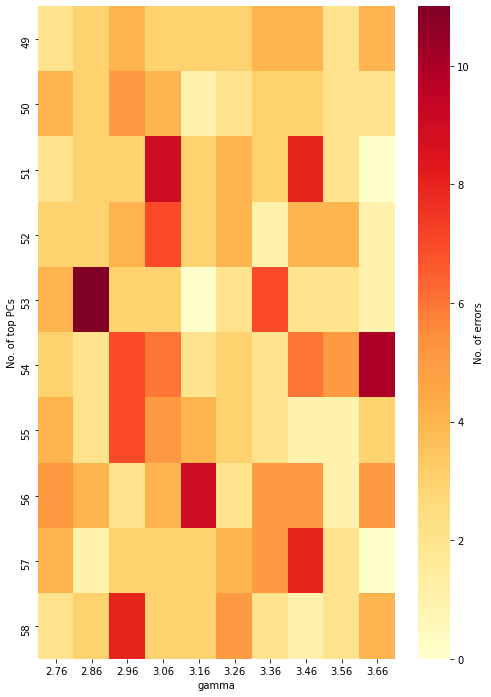

In [4]:
import math
import seaborn as sb

# method that returns number of errors made by the multi-class perceptron
def get_errors(w, data_x, data_y):
    errors = 0
    array = np.zeros((w.shape[0],1))
    
    for i in range(len(data_x)):
        
        for x in range(len(array)):
                array[x] = data_x[i].dot(w[x].T)
                
        value = np.argmax(array)
        if value != data_y[i]:
            errors += 1
    return errors

# centered data, gamma as arguments. method to calculate Ktild
def k_tild(centered_x, gamma):
    K = np.zeros((centered_x.shape[0],centered_x.shape[0]))
    for i in range(len(K)):
        for j in range(len(K)):
            K[i][j] = math.exp(-1*gamma*(np.sum(np.square(centered_x[i] - centered_x[j]))))

    A = np.full((K.shape),1/K.shape[0])
    Ktild = K - A.dot(K) - K.dot(A) + (A.dot(K)).dot(A)
    return Ktild

# returns a range of PCs for search grid visualization
def pc_range(pc):
    if pc - 4 < 5:
        startPC = 5
        endPC = 14
    elif pc + 5 > 150:
        endPC = 150
        startPC = 141
    else:
        startPC = pc - 4
        endPC = pc + 5
    return (startPC, endPC)

# returns a range of gammas for search grid visualization
def gamma_range(gamma, minGamma, maxGamma):
    if gamma - 0.4 < minGamma:
        startGm = minGamma
        endGm = minGamma + 0.9
    elif gamma + 0.5 > maxGamma:
        endGm = maxGamma
        startGm = maxGamma - 0.9
    else:
        startGm = gamma - 0.4
        endGm = gamma + 0.5
    return (startGm, endGm)



variances = np.zeros((4,1))

for i in range(0,centered_x.shape[1]):
    variances[i] = np.var(centered_x[:,i])

minVar = variances[np.argmin(variances)]
maxVar = variances[np.argmax(variances)]
eps = 0.05

minGamma = 1/(2*(maxVar+eps))
maxGamma = 1/(2*(minVar-eps))

gammas = np.arange(minGamma, maxGamma, 0.1)
perfPC = 0
perfGm = 0
perfectFound = False

# Finding the perfect mutli-class perceptron
print("Performing grid search to determine PCs and gamma values...")
for k in range(centered_x.shape[1]+1,centered_x.shape[0]):
    for x in gammas:
        Ktild = k_tild(centered_x, x)
        
        Uk, Sk, Vk = np.linalg.svd(Ktild, full_matrices=True)

        high_d = Ktild.dot(np.transpose(Vk[:k]))
        data = np.hstack((high_d, bias))
        w = np.full((3,k+1), 0.0)
        W = perceptron(data, iris_y, w)
        if accuracy(W, data, iris_y) == 100:
            perfPC = k
            perfGm = x
            perfectFound = True
            break
    if perfectFound:
        break

# Hyper parameters selected - perfPC and perfGm for the perfect perceptron
print("Hyperparameters selected, displaying search grid...")

# Range of PCs and gammas values for search grid visualization
startPC, endPC = pc_range(perfPC)
startGm, endGm = gamma_range(perfGm, minGamma, maxGamma)
    

gammas = np.linspace(startGm, endGm, 10)
pcs = np.linspace(startPC, endPC, 10)

Aerr = np.zeros((10,10))
Ax = 0
Ay = 0

# Creating an Aerr matrix storing no. of errors of
# several multi-class perceptrons.
for x in gammas:
    Ktild = k_tild(centered_x, x)
    Uk, Sk, Vk = np.linalg.svd(Ktild, full_matrices=True)
    Ay = 0
    for k in range(startPC, endPC+1):
        if round(x[0],2) == round(perfGm,2) and k == perfPC:
            Aerr[Ax][Ay] = 0
            Ay += 1
        else:
            high_d = Ktild.dot(np.transpose(Vk[:k]))
            data = np.hstack((high_d, bias))
            w = np.full((3,k+1), 0.0)
            W = perceptron(data, iris_y, w)
            Aerr[Ax][Ay] = get_errors(W,data,iris_y)
            Ay += 1
    Ax += 1

# Displaying the search grid using matplotlib and seaborn.
print("Perfect Multi-Class perceptron with least PCs -",perfPC,"PCs and gamma with value",round(perfGm,2))
Aerr = Aerr.T.T.T
fig, ax = plt.subplots(figsize=(8,12))
pcs = pcs.astype(int)
gammas = np.round(gammas,2).reshape(1,10)
gammas = gammas[0]

cmap = sb.color_palette("YlOrRd", as_cmap=True)
heat_map = sb.heatmap(Aerr, xticklabels=gammas, yticklabels=pcs, cmap=cmap, ax=ax, cbar_kws={'label': 'No. of errors'})
plt.xlabel("gamma")
plt.ylabel("No. of top PCs")
plt.show()